# S:787 Two component regulatory system

In [1]:
from Genome.pangenome_annotate.gold_anno_downstream import *
from ddot import Ontology
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline
root_dir = '/home/hermuba/data0118/fig/'

# our ontology
ont2 = Ontology.from_table('/home/hermuba/data0118/network1122/candidate_ontologies')
# align to aro
align_aro = pd.read_csv('~/data0118/network1122/candidate_ontologies_term_anno.csv', header = 0, index_col = 0)
align_aro.set_index('index', inplace = True)

# load original gene annotation
gold_anno = pd.read_pickle('/home/hermuba/data0118/goldstandard/ec_rmplasmid_node_anno_df')

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


In [2]:
align_aro.head()

,Term,Similarity,FDR,Accession,Name,Description
index,,,,,,
S:582,ARO:3002804,0.905955,0.0,ARO:3002804,FosA2,An enzyme that confers resistance to fosfomyci...
S:590,ARO:3002594,0.884570,0.0,ARO:3002594,AAC(6')-IIa,AAC(6')-IIa is an aminoglycoside acetyltransfe...
S:589,ARO:3002660,0.883425,0.0,ARO:3002660,APH(6)-Id,APH(6)-Id is an aminoglycoside phosphotransfer...
S:608,ARO:3000676,0.879019,0.0,ARO:3000676,H-NS,H-NS is a histone-like protein involved in glo...
S:630,ARO:3004126,0.878897,0.0,ARO:3004126,Escherichia coli LamB,LamB is a negative regulator for antibiotic re...


# Explore Annotation in branch

In [3]:
# extract branch
s787_br = ont2.focus(branches = 'S:787')

# extract annotations
s787_genes = gold_anno.loc[s787_br.genes]

Genes and Terms to keep: 126


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


In [4]:
# explore annotation status, existing annotation is quite rare
s787_genes[['cog_ID', 'strict_best_ARO', 'resfam']].count()

cog_ID             84
strict_best_ARO    10
resfam             88
dtype: int64

## COG annotation

In [5]:
popular_cogs = count_cog(s787_genes)

In [6]:
# classify into regulator and effector

popular_cogs.loc[(popular_cogs['name'].str.contains('regulator')) |(popular_cogs['name'].str.contains('HTH'))|(popular_cogs['name'].str.contains('REC')), 'category'] = 'Regulator'
popular_cogs.loc[(popular_cogs['name'].str.contains('histidine')) , 'category'] = 'Sensor'


In [7]:
# having both
both = (popular_cogs['name'].str.contains('regulator')) |(popular_cogs['name'].str.contains('HTH')) &(popular_cogs['name'].str.contains('histidine')) |(popular_cogs['name'].str.contains('REC'))

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


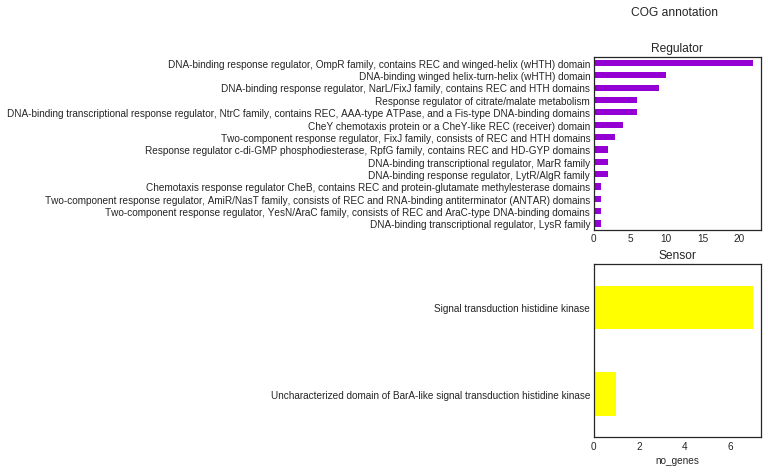

In [8]:
f,ax = plt.subplots(2,1, figsize = (3,7))
popular_cogs.loc[popular_cogs['category'] == 'Regulator'].set_index('name')['no_genes'].plot.barh(ax = ax[0], color = 'darkviolet', title = 'Regulator')
popular_cogs.loc[popular_cogs['category'] == 'Sensor'].set_index('name')['no_genes'].plot.barh(ax = ax[1], color = 'yellow', title = 'Sensor')
plt.suptitle('COG annotation')
_ = [ax[i].set_ylabel('') for i in range(2)]
ax[1].set_xlabel('no_genes')
plt.tight_layout()
plt.savefig(root_dir+'s787_cog_bar.pdf', dpi = 300)

In [9]:
regulator_cog = popular_cogs.loc[popular_cogs['category'] == 'Regulator'].index
sensor_cog = popular_cogs.loc[popular_cogs['category'] == 'Sensor'].index

In [10]:
s787_genes.loc[s787_genes['cog_ID'].isin(regulator_cog), 'category'] = 'Regulator'
s787_genes.loc[s787_genes['cog_ID'].isin(sensor_cog), 'category'] = 'Sensor'

popular_cogs.to_csv(root_dir+'S787_cog.csv')

In [11]:
import numpy as np
import igraph

def map_annotation_to_igraph(igraph_obj, align_aro, new_res_genes, root, node_lbl = 'aro', node_color = 'hypo_nr'):
    ''' to map annotation to igraph object for the purpose of visualization
    '''
    keys = igraph_obj.vs['name'] # id are stored in here
    # weird .0 is added
    keys = [i[:-(len(i.split('.')[-1])+1)] for i in keys]
    
    igraph_obj.vs['size'] = [12 if 'S:' in i else 10 for i in keys]
    igraph_obj.vs['label_size'] = [12 if 'S:' in i else 6 for i in keys]
    
    # resfam annotation(gene)
    igraph_obj.vs['resfam'] = [new_res_genes.loc[i, 'resfam'] if i in new_res_genes.index else '' for i in keys]
    # aro annotation (gene use name, term use align aro)
    igraph_obj.vs['aro'] = [new_res_genes.loc[i, 'strict_best_ARO'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    # nr annotation
    igraph_obj.vs['nr'] = [new_res_genes.loc[i, 'nr'] if i in new_res_genes.index else '' for i in keys]
    # hypothetical or not
    igraph_obj.vs['hypo'] = [new_res_genes.loc[i, 'hypo_nr'] if i in new_res_genes.index else '' for i in keys]
    # category
    igraph_obj.vs['cog'] = [new_res_genes.loc[i, 'cog_ID'] if i in new_res_genes.index else '' for i in keys]
    igraph_obj.vs['two_component'] = [new_res_genes.loc[i, 'category'] if i in new_res_genes.index else '' for i in keys]
    
    # decide label
    if node_lbl == 'aro':
        igraph_obj.vs['label'] = [new_res_genes.loc[i, 'strict_best_ARO'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    else:
        igraph_obj.vs['label'] = [new_res_genes.loc[i, 'resfam'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    igraph_obj.vs['label'] = [i if type(i)==str else '' for i in igraph_obj.vs['label']]
    
    # color
    color_list = []
    
    for i in keys:
        if 'S:' in i:
            if i == root:
                color_list.append('red')
            else:
                color_list.append('grey')
                
        elif node_color == 'hypo_nr':
            if new_res_genes.loc[i, node_color] == True:
                color_list.append('blue')
            else:
                color_list.append('pink')
        elif node_color == 'category':
            if new_res_genes.loc[i, node_color] == 'Regulator':
                color_list.append('purple')
            elif new_res_genes.loc[i, node_color] == 'Sensor':
                color_list.append('yellow')
            else:
                color_list.append('pink')
    igraph_obj.vs['color'] = color_list
    return(igraph_obj)

# visualize s787 COG

In [12]:
s787 = ont2.focus(branches = 'S:787').unfold().to_igraph()

Genes and Terms to keep: 126


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


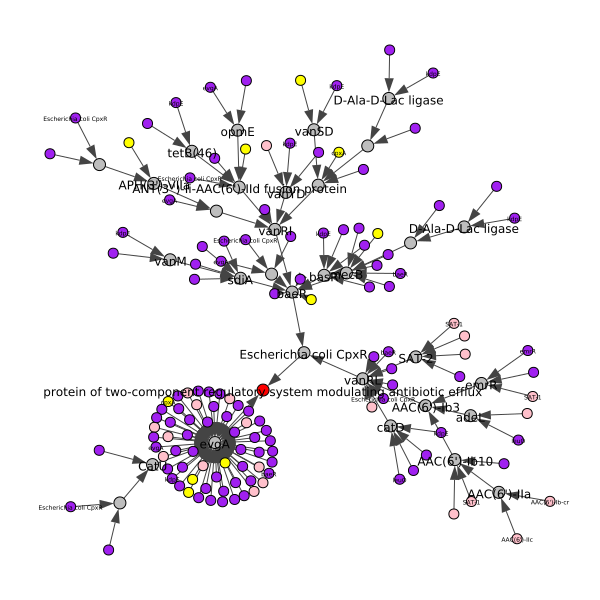

In [13]:
from igraph import *
s787 = map_annotation_to_igraph(s787, align_aro, s787_genes, 'S:787', node_lbl = 'aro', node_color = 'category')
layout = s787.layout("kk")
plot(s787, "s787_two_comp.pdf", layout = layout, margin = 50)



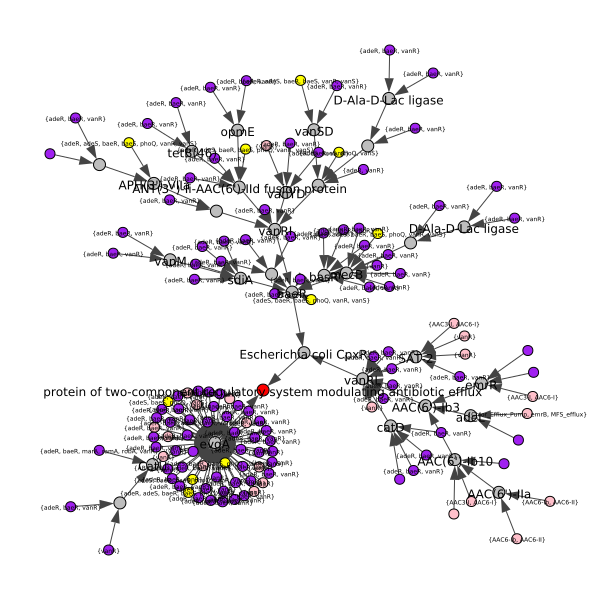

In [14]:
s787 = map_annotation_to_igraph(s787, align_aro, s787_genes, 'S:787', node_lbl = 'resfam', node_color = 'category')
plot(s787, "s787_two_comp.pdf", layout = layout, margin = 50)

In [15]:
s787_genes.to_csv(root_dir + 's787_total.csv')

In [16]:
regulator_domain = count_domain(s787_genes.loc[s787_genes['category'] == 'Regulator'])
sensor_domain = count_domain(s787_genes.loc[s787_genes['category'] == 'Sensor'])
hypo_domain = count_domain(s787_genes.loc[s787_genes['category'].isnull()])


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


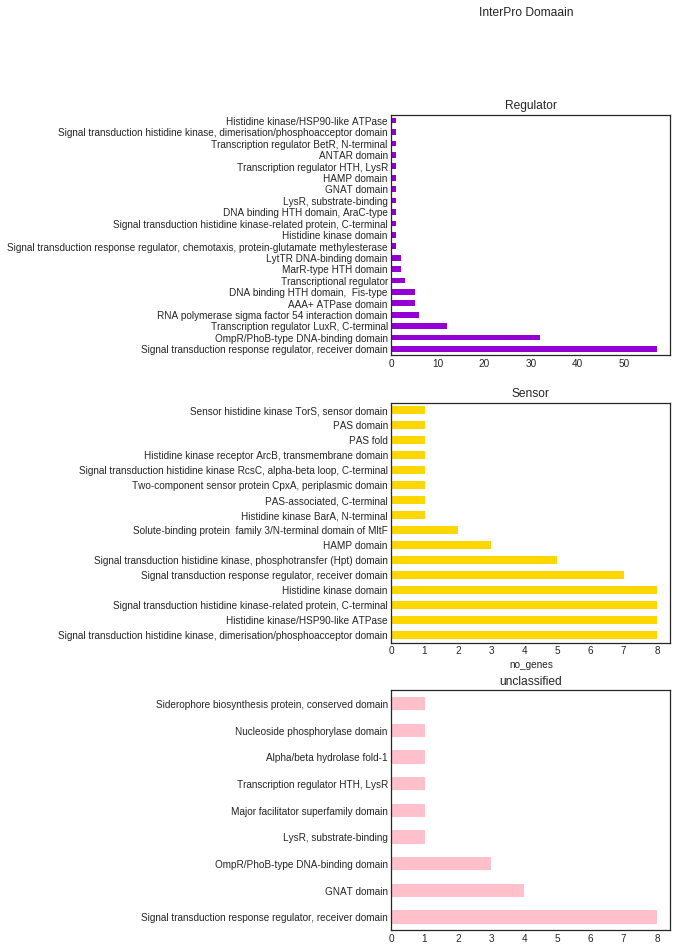

In [17]:
f,ax = plt.subplots(3,1, figsize = (5,15))
regulator_domain.loc[regulator_domain['ENTRY_TYPE'] == 'Domain'].set_index('ENTRY_NAME')['no_genes'].plot(kind = 'barh', ax = ax[0], title = 'Regulator', color = 'darkviolet')
sensor_domain.loc[sensor_domain['ENTRY_TYPE'] == 'Domain'].set_index('ENTRY_NAME')['no_genes'].plot(kind = 'barh', ax = ax[1], title = 'Sensor', color = 'gold')
hypo_domain.loc[hypo_domain['ENTRY_TYPE'] == 'Domain'].set_index('ENTRY_NAME')['no_genes'].plot(kind = 'barh', ax = ax[2], title = 'unclassified', color = 'pink')

plt.suptitle('InterPro Domaain')
_ = [ax[i].set_ylabel('') for i in range(3)]
ax[1].set_xlabel('no_genes')
plt.tight_layout()
plt.savefig(root_dir+'s787_domain_bar.pdf', dpi = 300)

# unknown genes

In [18]:
s787_genes.loc[s787_genes['hypo_nr'].notnull()]

,cog_ID,cog_category,cluster,count,core,loose_best_ARO,loose_ARO,strict_best_ARO,strict_ARO,is_card,...,aclame_title,is_aclame,nr,hypo_nr,drug_target,is_drug_target,GO,pathway,domain,category
562.22514.con.0046_7|562.22514,COG3710,K,Cluster 14402,4.0,False,NaN,NaN,NaN,NaN,False,...,NaN,False,WP_016262317.1 hypothetical protein [Escherich...,True,NaN,False,"{GO:0003677, GO:0000160, GO:0006355}",NaN,"{IPR001867, IPR016032, IPR036388}",Regulator
562.22679.con.0075_5|562.22679,COG4565,T,Cluster 12464,42.0,False,arlR,"ARO:3000828, ARO:3002973, ARO:3002924, ARO:300...",NaN,NaN,False,...,NaN,False,ELG51287.1 hypothetical protein A1Y1_02109 [Es...,True,NaN,False,"{GO:0000160, GO:0003700}",NaN,"{IPR024187, IPR011006, IPR001789}",Regulator
562.23686.con.0044_4|562.23686,COG3710,K,Cluster 14626,1.0,False,NaN,NaN,NaN,NaN,False,...,protein:plasmid:25091 Length: 152 # NCBI annot...,True,WP_021564222.1 MULTISPECIES: hypothetical prot...,True,NaN,False,"{GO:0003677, GO:0000160, GO:0006355}",NaN,"{IPR001867, IPR016032, IPR036388}",Regulator
FLWH01000003_469|562.12962,COG0745,T,Cluster 12717,3.0,False,adeR,"ARO:3000590, ARO:3002919, ARO:3002924, ARO:300...",NaN,NaN,False,...,protein:plasmid:21328 Length: 256 # NCBI annot...,True,EKB65527.1 hypothetical protein HMPREF1305_022...,True,NaN,False,"{GO:0003677, GO:0000160, GO:0006355}",NaN,"{IPR001789, IPR036388, IPR016032, IPR011006, I...",Regulator
FLWH01000005_148|562.12962,COG3710,K,Cluster 13871,2.0,False,NaN,NaN,NaN,NaN,False,...,NaN,False,EKB63136.1 hypothetical protein HMPREF1305_047...,True,NaN,False,"{GO:0003677, GO:0000160, GO:0006355}",NaN,"{IPR001867, IPR016032, IPR036388}",Regulator
JMUY01000001_188|1438670.3,COG0745,T,Cluster 13538,1573.0,True,baeR,"ARO:3002136, ARO:3000828, ARO:3002924, ARO:300...",NaN,NaN,False,...,protein:plasmid:114038 Length: 239 # NCBI anno...,True,EFE63531.1 hypothetical protein ECCG_01415 [Es...,True,NaN,False,"{GO:0003677, GO:0000160, GO:0006355}",NaN,"{IPR001867, IPR011006, IPR036388, IPR001789}",Regulator


In [19]:
aac = s787_genes.loc[s787_genes['resfam'].notnull()]['resfam'][s787_genes.loc[s787_genes['resfam'].notnull()]['resfam'].str.contains('AAC')].index
s787_genes.loc[aac]

,cog_ID,cog_category,cluster,count,core,loose_best_ARO,loose_ARO,strict_best_ARO,strict_ARO,is_card,...,aclame_title,is_aclame,nr,hypo_nr,drug_target,is_drug_target,GO,pathway,domain,category
562.22588.con.0084_1|562.22588,COG1670,J,Cluster 13419,118.0,False,NaN,NaN,AAC(6')-Ib-cr,"ARO:3002548, ARO:3002577, ARO:3002592, ARO:300...",True,...,protein:plasmid:148158 Length: 199 # NCBI anno...,True,WP_012783948.1 MULTISPECIES: AAC(6')-Ib family...,NaN,NaN,False,NaN,NaN,"{IPR030971, IPR000182, IPR016181}",NaN
562.23367.con.0030_45|562.23367,COG0596,R,Cluster 3490,100.0,False,NaN,NaN,SAT-1,ARO:3002895,True,...,protein:plasmid:117760 Length: 359 # NCBI anno...,True,WP_071846307.1 bifunctional putative esterase ...,NaN,NaN,False,NaN,NaN,"{IPR000182, IPR000073, IPR029058, IPR008125, I...",NaN
JAPE01000025_173|1400157.3,COG1670,J,Cluster 15696,14.0,False,NaN,NaN,AAC(6')-IIc,"ARO:3002548, ARO:3002577, ARO:3002592, ARO:300...",True,...,protein:plasmid:17003 Length: 201 # NCBI annot...,True,WP_012695484.1 MULTISPECIES: aminoglycoside N-...,NaN,NaN,False,NaN,NaN,"{IPR030971, IPR016181, IPR019432, IPR000182}",NaN


In [20]:
count_domain(s787_genes.loc[aac])

,ENTRY_TYPE,ENTRY_NAME,no_genes
ENTRY_AC,,,
IPR000182,Domain,GNAT domain,3
IPR016181,Homologous_superfamily,Acyl-CoA N-acyltransferase,3
IPR030971,Family,"Aminoglycoside N(6')-acetyltransferase, AacA4 ...",2
IPR019432,Domain,"Siderophore biosynthesis protein, conserved do...",1
IPR000073,Domain,Alpha/beta hydrolase fold-1,1
IPR008125,Family,Streptothricin acetyltransferase,1
IPR029058,Homologous_superfamily,Alpha/Beta hydrolase fold,1


# resfam

In [21]:
all_resfam = set()
_ = [all_resfam.update(set(i[1:-1].split(', '))) for i in s787_genes['resfam'] if type(i)!= float]
all_resfam.update(set(['ABCAntibioticEffluxPump', 'Chloramphenicol_Efflux_Pump', 'MFSAntibioticEffluxPump'])) # seem to have older versions of name in metadata
resfam_metadata = pd.read_excel('/nas/hermuba/180102_resfams_metadata_updated_v122.xlsx', header = 3)
resfam_metadata = resfam_metadata.loc[resfam_metadata['Resfam Family Name'].isin(all_resfam)]
resfam_metadata.set_index('Resfam Family Name', inplace = True)
resfam_metadata = resfam_metadata[['ResfamID', 'Description', 'CARD_ARO_Updated', 'Mechanism Classification']]
resfam_metadata.index = ['AAC3-I', 'AAC6-I', 'AAC6-Ib', 'AAC6-II', 'ABC_efflux',
       'adeR', 'adeS', 'baeR', 'baeS', 'Chlor_Efflux_Pump', 'emrB',
       'marA', 'MFS_efflux', 'phoQ', 'ramA', 'robA', 'vanR',
       'vanS']
resfam_metadata['count'] = 0
for i in s787_genes['resfam']:
    if type(i) != float:
        family = i[1:-1].split(', ')
        
        resfam_metadata.loc[family, 'count'] = resfam_metadata.loc[family, 'count'] + 1

In [22]:
resfam_metadata = resfam_metadata.sort_values(by = 'count', ascending = False)

In [23]:
resfam_metadata

,ResfamID,Description,CARD_ARO_Updated,Mechanism Classification,count
vanR,RF0154,VanR: transcriptional activator regulating Van...,ARO:3002976; ARO:3000574,Gene Modulating Resistance,83
baeR,RF0035,baeR: subunit of gene modulating antibiotic ef...,ARO:3000451; ARO:3000750; ARO:3000828,Gene Modulating Resistance,62
adeR,RF0022,adeR: positive regulator of AdeABC efflux system,ARO:3000451; ARO:3000553,Other Efflux,57
vanS,RF0155,VanS: trasncriptional regulator of van glycope...,ARO:3002976; ARO:3000071,Gene Modulating Resistance,9
adeS,RF0023,adeS: gene modulating antibiotic efflux regula...,ARO:3000451; ARO:3000549,Other Efflux,8
baeS,RF0036,baeS: subunit of gene modulating antibiotic ef...,Not Available,Gene Modulating Resistance,8
phoQ,RF0112,phoQ: subunit of gene modulating antibiotic ef...,Not Available,Gene Modulating Resistance,7
AAC6-Ib,RF0005,Aminoglycoside Acetyltransferase (AAC6-Ib),ARO:3000121; ARO:3000345,Acetyltransferase,2
AAC6-II,RF0006,Aminoglycoside Acetyltransferase (AAC6-II),ARO:3000121; ARO:3000345,Acetyltransferase,2
MFS_efflux,RF0104,major facilitator superfamily (MFS) antibiotic...,ARO:0010002,MFS Transporter,1


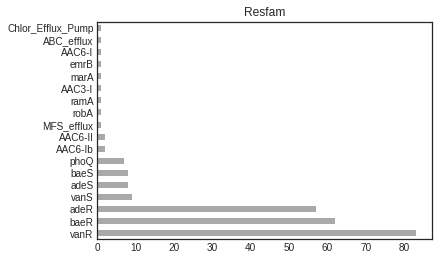

In [24]:
resfam_metadata['count'].plot(kind = 'barh', title = 'Resfam', color = 'darkgray')
plt.savefig(root_dir+'s787_resfam_bar.pdf', dpi = 300)